In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy
from collections import defaultdict
import xml.etree.ElementTree as ET
import os
import numpy as np
import random
import copy
import pandas as pd
import xmltodict
from tqdm import tqdm

In [2]:
def load_from_xml(path):
    """

    :param path: path file

    :return: dict[frame_num] = [[x1, y1, x2, y2]]
    """
    
    with open(path) as f:
        tracks = xmltodict.parse(f.read())['annotations']['track']

    gt = defaultdict(list)
    num_iter = 0
    for track in tracks:
        label = track['@label']
        boxes = track['box']
        for box in boxes:
            if label == 'car':
                frame=int(box['@frame'])
                frame = f'f_{frame}'
                gt[frame].append(
                    [float(box['@xtl']),
                    float(box['@ytl']),
                    float(box['@xbr']),
                    float(box['@ybr'])]
                )
                num_iter += 1

            else:
                continue

    return gt, num_iter

In [3]:
def load_from_txt(path):
    """
    :param path: path file

    :return: list = [[frame,x1, y1, x2, y2, conf]]
    """
    frame_list = []
    with open(path) as f:
        lines = f.readlines()
   
    for l in lines:
        ll = l.split(',')
        frame = f'f_{int(ll[0]) - 1}'
        frame_list.append([frame,float(ll[2]), float(ll[3]),
                                            float(ll[2]) + float(ll[4]), float(ll[3])+float(ll[5]),ll[6]])
        


    return frame_list

In [4]:
def generate_noisy_boxes(gt_boxes, del_prob,gen_prob, mean, std,frame_shape=[1080, 1920]):
    """
    :gt_boxes: ground truth bounding boxes dict
    :del_prob: probability to delete bounding boxes
    :gen_prob: probability to generate bounding boxes
    :return: list with the noisy bounding boxes list = [[frame,x1, y1, x2, y2]]
    """
    noisy_bboxes = []
    gt_total = 0
    for frame,bboxes in gt_boxes.items():
        for bbox in bboxes:
            gt_total += 1
            if np.random.random() > del_prob:
                xtl, ytl, xbr, ybr = bbox
                noise = np.random.normal(mean,std,4)
                noisy_bboxes.append([frame,xtl+noise[0], ytl+noise[1], xbr+noise[2], ybr+noise[3]])
                w = xbr - xtl
                h = ybr - ytl

        if np.random.random() <= gen_prob:
            x = np.random.randint(w, frame_shape[1]-w)
            y = np.random.randint(h, frame_shape[0]-h)
            noisy_bboxes.append([frame,x-w/2, y-w/2, x+w/2, y+w/2])


    return noisy_bboxes


In [5]:
def iou(box1, box2):
    if len(box1) > 4:
        box1=box1[:4]
    x11, y11, x12, y12 = box1
    x21, y21, x22, y22 = box2
    xA = np.maximum(x11, x21)
    yA = np.maximum(y11, y21)
    xB = np.minimum(x12, x22)
    yB = np.minimum(y12, y22)
    interArea = np.maximum(0, xB - xA + 1) * np.maximum(0, yB - yA + 1)
    boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
    boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
    iou = interArea / np.float64(boxAArea + boxBArea - interArea)
    return iou

In [6]:
def mean_AP_Pascal_VOC(gt_boxes,N_gt,predicted_boxes,iou_th):
    """
    :gt_boxes: ground truth bounding boxes dict
    :N_gt: Total of ground truth bounding boxes
    :predicted_boxes: predicted bounding boxes
    :return: mean IOU, average precision
    """
    mIOU = 0
    tp = np.zeros(len(predicted_boxes))
    fp = np.zeros(len(predicted_boxes))
    gt_detected = copy.deepcopy(gt_boxes)

    for i in range(len(predicted_boxes)):
        frame = predicted_boxes[i][0]
        predicted = predicted_boxes[i][1:5]
        gt = gt_detected[frame]
        iou_score = []
        if len(gt) != 0:
            for b in range(len(gt)):
                iou_score.append(iou(gt[b],predicted))
            id = np.argmax(iou_score)
            max_iou = iou_score[id]
            mIOU += max_iou

            if max_iou >= iou_th:
                if len(gt_detected[frame][id]) == 4:
                    gt_detected[frame][id].append(True)
                    tp[i] = 1
                else:
                    fp[i] = 1
            else:
                fp[i] = 1

    tp = np.cumsum(tp)
    fp = np.cumsum(fp)

    recall = tp/ float(N_gt)
    precision = tp/np.maximum(tp + fp, np.finfo(np.float64).eps)

    ap = 0.0
    for t in np.arange(0.0, 1.1, 0.1):
        if np.sum(recall >= t) == 0:
            p = 0
        else:
            p = np.max(precision[recall >= t])
        ap = ap + p / 11.0

    return mIOU/len(predicted_boxes), ap

In [7]:
def compute_confidences_ap(gt_boxes,N_gt,predicted_boxes,N=10,iou_th = 0.5):
    """ 
    Randomly generates the order of the bounding boxes to calculate the average precision (N times). 
    Average values will be returned.
    """
    ap_scores = []
    
    for i in tqdm(range(N)):
        random.shuffle(predicted_boxes)
        mIOU, ap = mean_AP_Pascal_VOC(gt_boxes,N_gt,predicted_boxes,iou_th)
        ap_scores.append(ap)
        

    return sum(ap_scores)/len(ap_scores),mIOU

TASK 1.1

In [24]:
gt_boxes,total = load_from_xml('/home/guillem/mcv-m6-2023-team6/dataset/ai_challenge_s03_c010-full_annotation.xml')
df = pd.DataFrame(columns=['mean','std','delete_probability','generate_probability','mIOU','mAP'])

NOISE PARAMETERS

In [9]:
mean = [-2,0,2]
std = [2,5,10,15]

for i in range(len(mean)):
    noisy_bboxes = generate_noisy_boxes(gt_boxes,del_prob=0.1,gen_prob=0.1,mean=mean[i],std=1)
    mAP,mIOU = compute_confidences_ap(gt_boxes,total,noisy_bboxes)
    df.at[i,'mean'] = mean[i]
    df.at[i,'std'] = 1
    df.at[i,'delete_probability'] = 0.1
    df.at[i,'generate_probability'] = 0.1
    df.at[i,'mIOU'] = mIOU
    df.at[i,'mAP'] = mAP


for i in range(len(std)):
    noisy_bboxes = generate_noisy_boxes(gt_boxes,del_prob=0.1,gen_prob=0.1,mean=0,std=std[i])
    mAP,mIOU = compute_confidences_ap(gt_boxes,total,noisy_bboxes)
    df.at[i+3,'mean'] = 0
    df.at[i+3,'std'] = std[i]
    df.at[i+3,'delete_probability'] = 0.1
    df.at[i+3,'generate_probability'] = 0.1
    df.at[i+3,'mIOU'] = mIOU
    df.at[i+3,'mAP'] = mAP


noisy_bboxes = generate_noisy_boxes(gt_boxes,del_prob=0.7,gen_prob=0.1,mean=0,std=1)
mAP,mIOU = compute_confidences_ap(gt_boxes,total,noisy_bboxes)
df.at[7,'mean'] = 0
df.at[7,'std'] = 1
df.at[7,'delete_probability'] = 0.7
df.at[7,'generate_probability'] = 0.1
df.at[7,'mIOU'] = mIOU
df.at[7,'mAP'] = mAP

noisy_bboxes = generate_noisy_boxes(gt_boxes,del_prob=0.1,gen_prob=0.7,mean=0,std=1)
mAP,mIOU = compute_confidences_ap(gt_boxes,total,noisy_bboxes)
df.at[8,'mean'] = 0
df.at[8,'std'] = 1
df.at[8,'delete_probability'] = 0.1
df.at[8,'generate_probability'] = 0.7
df.at[8,'mIOU'] = mIOU
df.at[8,'mAP'] = mAP





In [13]:
noisy_bboxes = generate_noisy_boxes(gt_boxes,del_prob=0.1,gen_prob=0.1,mean=-2,std=15)
mAP,mIOU = compute_confidences_ap(gt_boxes,total,noisy_bboxes)
df.at[9,'mean'] = -2
df.at[9,'std'] = 15
df.at[9,'delete_probability'] = 0.1
df.at[9,'generate_probability'] = 0.1
df.at[9,'mIOU'] = mIOU
df.at[9,'mAP'] = mAP

In [14]:
df

,mean,std,delete_probability,generate_probability,mIOU,mAP
0,-2,1,0.1,0.1,0.886239,0.810308
1,0,1,0.1,0.1,0.946687,0.900547
2,2,1,0.1,0.1,0.887883,0.901478
3,0,2,0.1,0.1,0.907345,0.901009
4,0,5,0.1,0.1,0.80149,0.807863
5,0,10,0.1,0.1,0.662955,0.631781
6,0,15,0.1,0.1,0.554706,0.363524
7,0,1,0.7,0.1,0.925992,0.266847
8,0,1,0.1,0.7,0.891479,0.767281
9,-2,15,0.1,0.1,0.552733,0.374511


TASK 1.2

● Compute the mAP for the provided detections (mask_rcnn, ssd512, yolo3)

In [49]:
maskrcnn = '/home/guillem/mcv-m6-2023-team6/dataset/AICity_data/train/S03/c010/det/det_mask_rcnn.txt'
yolo = '/home/guillem/mcv-m6-2023-team6/dataset/AICity_data/train/S03/c010/det/det_ssd512.txt'
ssd = '/home/guillem/mcv-m6-2023-team6/dataset/AICity_data/train/S03/c010/det/det_yolo3.txt'

In [90]:
paths = [maskrcnn,yolo,ssd]
for path in paths:
    boxes = load_from_txt(path)
    boxes.sort(key=lambda x:x[-1], reverse=True)
    mIOU,AP = mean_AP_Pascal_VOC(gt_boxes,total,boxes,iou_th=0.5)

    print(path.split('/')[-1],':')
    print(mIOU, AP)

det_mask_rcnn.txt :
0.6704569939675995 0.4127270049872833
det_ssd512.txt :
0.7871484668889996 0.36312765043241835
det_yolo3.txt :
0.6060181418575947 0.4427788684590106


TASK 2


In [8]:
gt_boxes,total = load_from_xml('/home/guillem/mcv-m6-2023-team6/dataset/ai_challenge_s03_c010-full_annotation.xml')

predicted_boxes = load_from_txt('/home/guillem/mcv-m6-2023-team6/dataset/AICity_data/train/S03/c010/det/det_mask_rcnn.txt')
predicted_boxes.sort(key=lambda x:x[-1], reverse=True)

video_capture = cv2.VideoCapture('/home/guillem/mcv-m6-2023-team6/dataset/AICity_data/train/S03/c010/vdo.avi')

# import itertools

 
# def group_by_frame(predicted_boxes):
#     """Group the detected boxes by frame_id as a dictionary"""
#     predicted_boxes.sort(key=lambda x: x[0])
#     predicted_boxes = itertools.groupby(predicted_boxes, key=lambda x: x[0])
#     predicted_boxes = {k: list(v) for k, v in predicted_boxes}
#     return predicted_boxes


# # Group the detected boxes by frame_id as a dictionary
# predicted_boxes_group = group_by_frame(predicted_boxes)



print(gt_boxes['f_86'])
# print(predicted_boxes_group['f_86'])



[[536.35, 41.15, 591.37, 81.14], [558.36, 94.45, 663.49, 169.31], [573.7, 72.89, 661.41, 145.05], [913.24, 93.02, 972.14, 144.57], [894.24, 95.32, 944.92, 144.0], [878.4, 107.28, 927.5, 145.72], [1176.01, 82.17, 1253.12, 174.08], [1285.84, 363.23, 1516.36, 546.91], [931.96, 78.33, 1013.32, 146.01]]


['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27', 'f_28', 'f_29', 'f_30', 'f_31', 'f_32', 'f_33', 'f_34', 'f_35', 'f_36', 'f_37', 'f_38', 'f_39', 'f_40', 'f_41', 'f_42', 'f_43', 'f_44', 'f_45', 'f_46', 'f_47', 'f_48', 'f_49', 'f_50', 'f_51', 'f_52', 'f_53', 'f_54', 'f_55', 'f_56', 'f_57', 'f_58', 'f_59', 'f_60', 'f_61', 'f_62', 'f_63', 'f_64', 'f_65', 'f_66', 'f_67', 'f_68', 'f_69', 'f_70', 'f_71', 'f_72', 'f_73', 'f_74', 'f_75', 'f_76', 'f_77', 'f_78', 'f_79', 'f_80', 'f_81', 'f_82', 'f_83', 'f_84', 'f_85', 'f_86', 'f_87', 'f_88', 'f_89', 'f_90', 'f_91', 'f_92', 'f_93', 'f_94', 'f_95', 'f_96', 'f_97', 'f_98', 'f_99', 'f_100', 'f_101', 'f_102', 'f_103', 'f_104', 'f_105', 'f_106', 'f_107', 'f_108', 'f_109', 'f_110', 'f_111', 'f_112', 'f_113', 'f_114', 'f_115', 'f_116', 'f_117', 'f_118', 'f_119', 'f_120', 'f_121', 'f_122', 'f

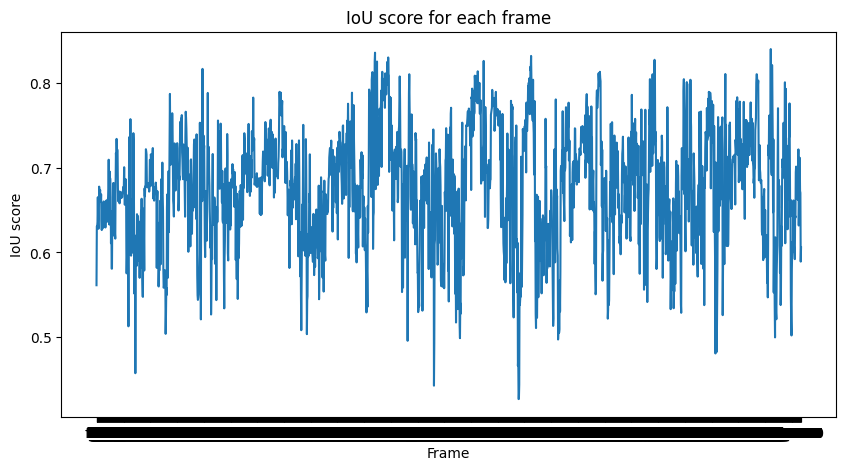

In [12]:
total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))

iou_frames = {} 
for i in range(len(predicted_boxes)):
    frame = predicted_boxes[i][0]
    predicted = predicted_boxes[i][1:5]
    gt = gt_boxes[frame]
    iou_score = []
    if len(gt) != 0:
        for b in range(len(gt)):
            iou_score.append(iou(gt[b],predicted))
        id = np.argmax(iou_score)
        max_iou = iou_score[id]
        if frame not in iou_frames:
            iou_frames[frame] = []
        iou_frames[frame].append(max_iou)


# Plot the IoU score for each frame
plt.figure(figsize=(10,5))
frames = list(iou_frames.keys())
# sort the frames
frames.sort(key=lambda x: int(x.split('_')[1]))
print(frames)
iou_scores = [np.mean(iou_frames[frame]) for frame in frames]
plt.plot(frames, iou_scores)
plt.title('IoU score for each frame')
plt.xlabel('Frame')
plt.ylabel('IoU score')
plt.show()
